#### Notebook purpose
This notebooks aims to evaluate various machine learning models trained to classify news articles collected on http://eventregistry.org into 3 distinct categories, which are: politics, sports and other. Please refer to notebooks/workspace/0_extract_data.ipynb for details about the data extraction process.

After few early attempts at training a classifer to predict only 2 categories (sport vs politics) with the entire body of the articles I got almost perfect results which was suspicious. Since I didn't have enough time to double check where the information leak was, I decided to pivot a bit the problem by classifying documents into 3 categories and by limiting the content of the articles to the first 250 characters. 

For details about the split between the training and the test datasets please refer to notebooks/workspace/2_prepare_data_for_modeling.ipynb.

For classical machine learning models, we used the 5-folds cross validation f1 score (macro) as a selection criterion. The f1 score is a common measure in document classification that take into account both recall and precision. Please refer to notebooks/workspace/3_predictive_modelling_classical_ml.ipynb for details about the model selection process.

For the deep learning model we used an early stopping strategy on the validation categorical crossentropy to select the best model. Please refer to notebooks/workspace/4_predictive_modelling_deep_learning.ipynb for details about the model selection process.

#### Notes on the results
Losgistic regression models perform quite well on this problem and are fast to train. We observe that adding more features tend to increase their performance (cf notebooks/workspace/3_predictive_modelling_classical_ml.ipynb).

In the end the boosting model is the worst classifier, although if I had more time I could have done a grid search on a larger space which would have returned a more performant combination of parameters presumably.

Overall the deep learning model seems to perform slightly better. I didn't have enough time to use pretrained word embeddings but this is something to explore.

#### Load training and test X & y

In [1]:
import pandas as pd
from ast import literal_eval

In [2]:
data_path = '../../data/'
models_path = '../../models/'

In [3]:
X_train = pd.read_csv(f'{data_path}X_train.csv', converters={'event_list': literal_eval, 'person_list': literal_eval})
X_test = pd.read_csv(f'{data_path}X_test.csv', converters={'event_list': literal_eval, 'person_list': literal_eval})
y_train = pd.read_csv(f'{data_path}y_train.csv').values.ravel()
y_test = pd.read_csv(f'{data_path}y_test.csv').values.ravel()

In [4]:
import pickle, json

In [5]:
with open(f'{data_path}keras_data.pkl', 'rb') as f:
    keras_data = pickle.load(f)

#### Load deep learning model

In [6]:
with open(f'{models_path}keras_architecture.json', 'r') as f:
    architecture = json.load(f)

In [7]:
from keras.models import model_from_json

/home/quentin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
dl_clf = model_from_json(json.dumps(architecture))
dl_clf.load_weights(f'{models_path}keras_early_stopping.h5')

#### Load classical ML models

In [9]:
from sklearn.externals import joblib

In [10]:
logreg1 = joblib.load(f'{models_path}best_logreg1.pkl')
logreg2 = joblib.load(f'{models_path}best_logreg2.pkl')
boosting = joblib.load(f'{models_path}best_boosting.pkl')

#### Make predictions on the test set

In [11]:
from sklearn.metrics import f1_score

In [12]:
y_hat_dl_clf = dl_clf.predict(keras_data['test']).argmax(axis=1)
y_hat_logreg1 = logreg1.predict(X_test)
y_hat_logreg2 = logreg2.predict(X_test)
y_hat_boosting = boosting.predict(X_test)

In [13]:
f1_score_dl = f1_score(y_test, y_hat_dl_clf, average='macro')
f1_score_lr1 = f1_score(y_test, y_hat_logreg1, average='macro')
f1_score_lr2 = f1_score(y_test, y_hat_logreg2, average='macro')
f1_score_boosting = f1_score(y_test, y_hat_boosting, average='macro')

#### Compare performances between models

In [14]:
scores = pd.DataFrame({'f1 score (macro)': [f1_score_dl, f1_score_lr1, f1_score_lr2, f1_score_boosting], 
                       'model': ['deep learning', 'logreg f1-4', 'logreg f1-5', 'boosting']})
scores['model'] = scores.model.astype('category')

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
plt.style.use('seaborn-dark')
phq_palette = sns.color_palette(['#df477e', '#67bea3', '#5d8bc6', '#f4b543', '#e87d52', '#757570'])

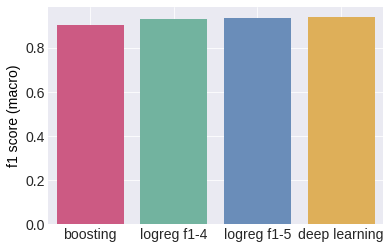

In [17]:
g = sns.barplot(x='model', y='f1 score (macro)', data=scores, palette=phq_palette,
                order=scores.sort_values('f1 score (macro)').model.tolist())
g.set_ylabel('f1 score (macro)', fontsize=14, color='black')    
g.set_xlabel('', fontsize=14, color='black')
g.tick_params(color='black', labelsize=14, width=0)
g.grid(b=True, which='major')

In [18]:
scores.sort_values('f1 score (macro)')

,f1 score (macro),model
3,0.904815,boosting
1,0.930115,logreg f1-4
2,0.932797,logreg f1-5
0,0.937821,deep learning


#### Check detailed report for each model

In [19]:
from sklearn.metrics import classification_report

In [20]:
print(classification_report(y_test, y_hat_dl_clf))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3300
           1       0.95      0.96      0.95      3299
           2       0.94      0.95      0.95      3298

   micro avg       0.94      0.94      0.94      9897
   macro avg       0.94      0.94      0.94      9897
weighted avg       0.94      0.94      0.94      9897



In [21]:
print(classification_report(y_test, y_hat_logreg1))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      3300
           1       0.96      0.94      0.95      3299
           2       0.95      0.92      0.94      3298

   micro avg       0.93      0.93      0.93      9897
   macro avg       0.93      0.93      0.93      9897
weighted avg       0.93      0.93      0.93      9897



In [22]:
print(classification_report(y_test, y_hat_logreg2))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      3300
           1       0.97      0.94      0.95      3299
           2       0.96      0.92      0.94      3298

   micro avg       0.93      0.93      0.93      9897
   macro avg       0.93      0.93      0.93      9897
weighted avg       0.93      0.93      0.93      9897



In [23]:
print(classification_report(y_test, y_hat_boosting))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      3300
           1       0.95      0.92      0.93      3299
           2       0.96      0.87      0.91      3298

   micro avg       0.90      0.90      0.90      9897
   macro avg       0.91      0.90      0.90      9897
weighted avg       0.91      0.90      0.90      9897

